In [1]:
cd D:\Nasteo\Datasetting

D:\Nasteo\Datasetting


In [2]:
import OpenEXR, Imath, numpy
pt = Imath.PixelType(Imath.PixelType.HALF) #pixel type
dtype = numpy.float16
temp = OpenEXR.InputFile("./Saved_low/EXROutput/1.exr")
dw = temp.header()['dataWindow']
print(temp.header())
img_shape = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

{'channels': {'B': HALF (1, 1), 'G': HALF (1, 1), 'R': HALF (1, 1)}, 'compression': ZIP_COMPRESSION, 'dataWindow': (0, 0) - (255, 127), 'displayWindow': (0, 0) - (255, 127), 'lineOrder': INCREASING_Y, 'pixelAspectRatio': 1.0, 'screenWindowCenter': (0.0, 0.0), 'screenWindowWidth': 1.0}


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Conv2D, Input,Conv2DTranspose, Lambda
from tensorflow.keras.layers import Concatenate, Dropout, MaxPooling2D, BatchNormalization, BatchNormalization, Dense, Reshape, Activation, Resizing
from tensorflow.keras import Model
import keras.backend as K
import tensorflow_addons as tfa
import pickle
import math

In [4]:
#-------------------------------------------DECLARATIONS-----------------------------------------------#

In [20]:
#one image input: 
def get_one_input_image(num, path): 
    path_spec = path + str(num) + ".exr";

    input_img = OpenEXR.InputFile(path_spec)
    (col_r, col_g, col_b, dep, lab) = input_img.channels("RGBDL", pt)
    red = numpy.frombuffer(col_r, dtype)
    green = numpy.frombuffer(col_g, dtype)
    blue = numpy.frombuffer(col_b, dtype)
    depth = numpy.frombuffer(dep, dtype)
    label = numpy.frombuffer(lab, dtype)
    
    red.shape = (img_shape[1], img_shape[0])
    green.shape = (img_shape[1], img_shape[0])
    blue.shape = (img_shape[1], img_shape[0])
    depth.shape = (img_shape[1], img_shape[0])
    label.shape = (img_shape[1], img_shape[0])
    
    image_numpy = numpy.stack((red, green, blue, depth, label))
    return numpy.moveaxis(image_numpy, 0, -1).astype(dtype)

In [6]:
#one image output: 
def get_one_output_image(num, path): 
    path_spec = path + str(num) + ".exr";
    input_img = OpenEXR.InputFile(path_spec)
    (col_r, col_g, col_b) = input_img.channels("RGB", pt)
    red = numpy.frombuffer(col_r, dtype)
    green = numpy.frombuffer(col_g, dtype)
    blue = numpy.frombuffer(col_b, dtype)
    red.shape = (img_shape[1], img_shape[0])
    green.shape = (img_shape[1], img_shape[0])
    blue.shape = (img_shape[1], img_shape[0])
    
    image_numpy = numpy.stack((red, green, blue))
    return numpy.moveaxis(image_numpy, 0, -1).astype(dtype)

In [7]:
from matplotlib import pyplot as plt
def show_img(img):
    plt.imshow(img[:, :, :].astype(numpy.float32), interpolation='nearest')
    plt.show()

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
from tensorflow.keras.utils import Sequence
import random

class DataGenerator(Sequence):
    def __init__(self, batch_size, number_of_batches, is_train):
        self.number_of_batches = number_of_batches
        self.batch_size = batch_size
        self.total_examples = batch_size*number_of_batches
        if (is_train):
            self.pathX = "./Saved_low_Model_Depth/EXRInput/"
            self.pathY = "./Saved_low_Model_Depth/EXROutput/"
        else:
            self.pathX = "./Saved_low_Model_test_Depth/EXRInput/"
            self.pathY = "./Saved_low_Model_test_Depth/EXROutput/"

    def __len__(self):
        return self.number_of_batches

    def __getitem__(self, index):
        batch_inputs = numpy.empty((self.batch_size, 128, 256, 5), dtype=dtype)
        batch_outputs = numpy.empty((self.batch_size, 128, 256, 3), dtype=dtype)
        # skip_rows = index * self.batch_size
        # counter = skip_rows + 1
        for i in range(self.batch_size):
            counter = random.randint(1, self.total_examples)
            batch_inputs[i] = get_one_input_image(counter, self.pathX )
            batch_outputs[i] = get_one_output_image(counter, self.pathY )
            # counter += 1
            # if(counter == self.total_examples):
            #     counter = 1 
        return batch_inputs.astype(dtype), batch_outputs.astype(dtype)

In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x =  tfa.layers.WeightNormalization(Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation="relu"))(input_tensor)
    x =  tfa.layers.WeightNormalization(Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation="relu"))(x)
    return x
    
def get_unet(n_filters = 16, dropout = 0.1):
    #Input layer and Embedding
    input_img = keras.Input(shape=(128, 256, 5), dtype=dtype)
    
    in_label_shape = (4, 8, 1)
    n_classes = 5
    in_label = Lambda(lambda x: x[:, 0, 0, 4])(input_img)    
    li = Embedding(n_classes, 4*8, input_length=1)(in_label)
    n_nodes = in_label_shape[0] * in_label_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_label_shape[0], in_label_shape[1], 1))(li)
    li = Resizing(128, 256)(li)
    li = tf.keras.layers.Rescaling(scale=1, offset=0.5)(li)

    in_image = input_img[:, :, :, 0:4]
    
    input_img_embed = Concatenate()([in_image, li])
    
    # Contracting Path
    c1 = conv2d_block(input_img_embed, n_filters * 1, kernel_size = 3)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = Concatenate()([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = Concatenate()([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = Concatenate()([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = Concatenate()([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3)
    
    outputs = Conv2D(filters=3, kernel_size = 3, strides=1, padding='same', activation='relu')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [11]:
# Loss functtion
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

In [12]:
# dict_keys(['loss', 'ssim_loss', 'mean_squared_error', 'mean_absolute_error', 'PSNR'])
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, log_after_N_batches):
        self.log_after_N_batches = log_after_N_batches
        self.counter = 0
        self.logger_train_ssim = []
        self.logger_train_mse = []
        self.logger_train_mae = []
        self.logger_train_psnr = []
        self.logger_test_ssim = []
        self.logger_test_mse = []
        self.logger_test_mae = []
        self.logger_test_psnr = []
        
    def on_train_batch_end(self, batch, logs=None):
        self.counter += 1
        if (self.counter == self.log_after_N_batches):
            self.logger_train_ssim.append(logs["ssim_loss"])
            self.logger_train_mse.append(logs["mean_squared_error"])
            self.logger_train_mae.append(logs["mean_absolute_error"])
            self.logger_train_psnr.append(logs["PSNR"])
            self.counter = 0
        
    def on_test_batch_end(self, batch, logs=None):
        self.counter += 1
        if (self.counter == self.log_after_N_batches):
            self.logger_test_ssim.append(logs["ssim_loss"])
            self.logger_test_mse.append(logs["mean_squared_error"])
            self.logger_test_mae.append(logs["mean_absolute_error"])
            self.logger_test_psnr.append(logs["PSNR"])
            self.counter = 0
            
    def get_train_logs(self):
        return [self.logger_train_ssim, self.logger_train_mse, self.logger_train_mae, self.logger_train_psnr]
    
    def get_test_logs(self):
        return [self.logger_test_ssim, self.logger_test_mse, self.logger_test_mae, self.logger_test_psnr]

In [13]:
#------------------------------------------TRAIN---------------------------------------#

In [ ]:
unet_example = get_unet()
# unet_example.summary()

In [ ]:
# loss <<<----
# varibale <<<----
unet_example.compile(optimizer="adam", loss=ssim_loss, metrics=[ssim_loss, "mean_squared_error", "mean_absolute_error", PSNR])

In [ ]:
batch_size = 40
number_of_batches = 455*3
batch_size_t = 20
number_of_batches_t = 455
actual_epoches = 2 # <<<----
loggerCallback = CustomCallback(log_after_N_batches = 20)
with tf.device('/GPU:0'):
    # varibale <<<----
    unet_example.fit(x = DataGenerator(batch_size, number_of_batches, is_train=True), epochs=actual_epoches, verbose = 1, validation_data=DataGenerator(batch_size_t, number_of_batches_t, is_train=False), callbacks=[loggerCallback])

In [22]:
train_metrics = loggerCallback.get_train_logs()
test_metrics = loggerCallback.get_test_logs()
print(len(train_metrics[0]))
print(len(test_metrics[0]))

136
46


In [ ]:
#-------------------------------------------WRITE METRICS------------------------------------#

In [46]:
# write to file

train_to_write = train_metrics # <<<----
test_to_write = test_metrics # <<<----
path_name = "1epoch_full_MSE_2after3epoches_MSE_remaster" # <<<----

with open("MyLogs/" + path_name + "/train.txt", "wb") as fp:
    pickle.dump(train_to_write, fp)
    
with open("MyLogs/" + path_name + "/test.txt", "wb") as fp:
    pickle.dump(test_to_write, fp)

In [ ]:
#-----------------------------------CONCATS------------------------------------#

In [59]:
train_head = pretrain_loaded_ssim # <<<----
train_tail = train_loaded_ssim # <<<----

train_concated = [[*train_head[0], *train_tail[0]], \
       [*train_head[1], *train_tail[1]], \
       [*train_head[2], *train_tail[2]], \
       [*train_head[3], *train_tail[3]]]

print(len(train_concated[0]))
print(len(train_concated[1]))
print(len(train_concated[2]))
print(len(train_concated[3]))

408
408
408
408


In [60]:
test_head = pretest_loaded_ssim # <<<----
test_tail = test_loaded_ssim # <<<----

test_concated = [[*test_head[0], *test_tail[0]], \
       [*test_head[1], *test_tail[1]], \
       [*test_head[2], *test_tail[2]], \
       [*test_head[3], *test_tail[3]]]

print(len(test_concated[0]))
print(len(test_concated[1]))
print(len(test_concated[2]))
print(len(test_concated[3]))

138
138
138
138


In [61]:
# ssim_train_concat = train_concated
# ssim_test_concat = test_concated

In [55]:
# mae_train_concat = train_concated
# mae_test_concat = test_concated

In [58]:
# mse_train_concat = train_concated
# mse_test_concat = test_concated

In [ ]:
#-------------------------------------------READ METRICS------------------------------------#

In [51]:
# read from file
with open("MyLogs/1epoch_full_SSIM_3after3epoches_SSIM/train.txt", "rb") as fp:
    train_loaded_ssim = pickle.load(fp)
with open("MyLogs/1epoch_full_MSE_2after3epoches_MSE_remaster/train.txt", "rb") as fp:
    train_loaded_mse = pickle.load(fp)
with open("MyLogs/1epoch_full_MAE_3after3epoches_MAE/train.txt", "rb") as fp:
    train_loaded_mae = pickle.load(fp)
with open("MyLogs/1epoch_full_SSIM_3after3epoches_SSIM/test.txt", "rb") as fp:
    test_loaded_ssim = pickle.load(fp)
with open("MyLogs/1epoch_full_MSE_2after3epoches_MSE_remaster/test.txt", "rb") as fp:
    test_loaded_mse = pickle.load(fp)
with open("MyLogs/1epoch_full_MAE_3after3epoches_MAE/test.txt", "rb") as fp:
    test_loaded_mae = pickle.load(fp)

In [52]:
# read from file
with open("MyLogs/1epoch_full_SSIM_3epoches_SSIM/train.txt", "rb") as fp:
    pretrain_loaded_ssim = pickle.load(fp)
with open("MyLogs/1epoch_full_MSE_3epoches_MSE_remaster/train.txt", "rb") as fp:
    pretrain_loaded_mse = pickle.load(fp)
with open("MyLogs/1epoch_full_MAE_3epoches_MAE/train.txt", "rb") as fp:
    pretrain_loaded_mae = pickle.load(fp)
with open("MyLogs/1epoch_full_SSIM_3epoches_SSIM/test.txt", "rb") as fp:
    pretest_loaded_ssim = pickle.load(fp)
with open("MyLogs/1epoch_full_MSE_3epoches_MSE_remaster/test.txt", "rb") as fp:
    pretest_loaded_mse = pickle.load(fp)
with open("MyLogs/1epoch_full_MAE_3epoches_MAE/test.txt", "rb") as fp:
    pretest_loaded_mae = pickle.load(fp)

In [ ]:
#-------------------------------------------PLOT------------------------------------#

In [67]:
plt.rcParams["figure.figsize"] = [10.00, 6]
plt.rcParams["figure.autolayout"] = True
# plt.plot([1, 2], [1, 2])
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
# # plt.show()

<Figure size 720x432 with 0 Axes>

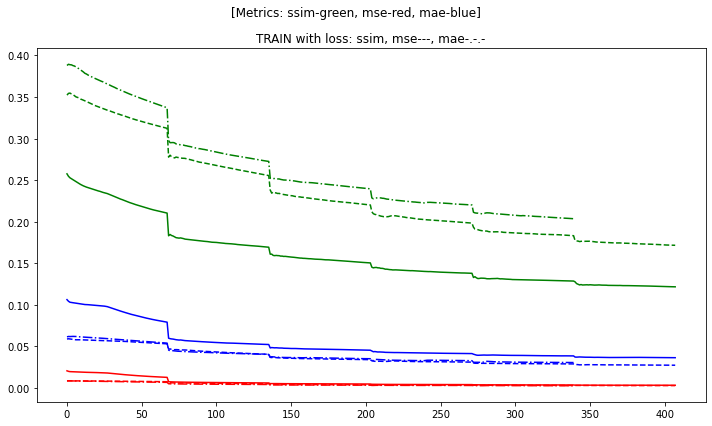

In [68]:
ssim_train = ssim_train_concat # <<<----
mse_train = mse_train_concat # <<<----
mae_train = mae_train_concat # <<<----

plt.plot(ssim_train[0], 'g', ssim_train[1], 'r', ssim_train[2], 'b', \
         mse_train[0], 'g-.', mse_train[1], 'r-.', mse_train[2], 'b-.', \
         mae_train[0], 'g--', mae_train[1], 'r--', mae_train[2], 'b--')
plt.suptitle('[Metrics: ssim-green, mse-red, mae-blue]')
plt.title('TRAIN with loss: ssim, mse---, mae-.-.-')
plt.show()

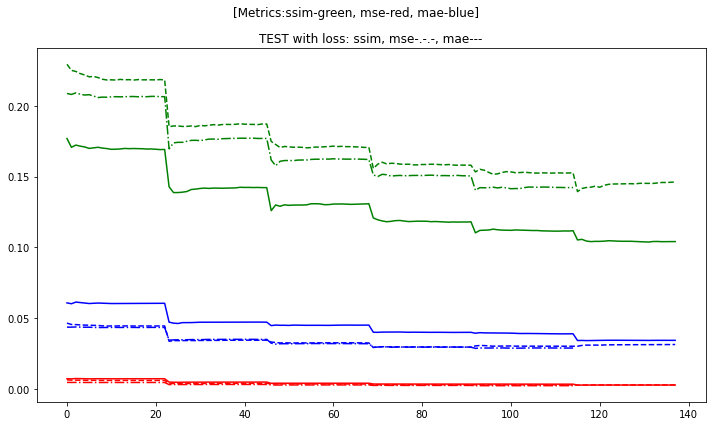

In [69]:
ssim_test = ssim_test_concat  # <<<----
mse_test = mse_test_concat  # <<<----
mae_test = mae_test_concat  # <<<----

plt.plot(ssim_test[0], 'g', ssim_test[1], 'r', ssim_test[2], 'b', \
         mse_test[0], 'g-.', mse_test[1], 'r-.', mse_test[2], 'b-.', \
         mae_test[0], 'g--', mae_test[1], 'r--', mae_test[2], 'b--')
plt.suptitle('[Metrics:ssim-green, mse-red, mae-blue]')
plt.title('TEST with loss: ssim, mse-.-.-, mae---')
plt.show()

In [ ]:
plt.plot(ssim_test[3], '', mse_test[3], '-.', mae_test[3], '--')
plt.suptitle('[Metrics:PSNR]')
plt.title('TEST with loss: ssim, mse-.-.-, mae---')
plt.show()

In [ ]:
#-------------------------------------------SAVE and LOAD WEIGHTS------------------------------------#

In [48]:
#save..
# CHECK VARIABLE AND PATH!!
unet_mse.save_weights("1epoch_full_MSE_2after3epoches_MSE_remaster")

In [ ]:
# CHECK VARIABLE AND PATH!!
load_status = unet_mse.load_weights("1epoch_full_MSE_3epoches_MSE_remaster") 

In [ ]:
load_status.assert_consumed()

In [ ]:
#-------------------------------------------PICTURES------------------------------------#

In [24]:
batch_inputs = numpy.empty((40, 128, 256, 5), dtype=dtype)
batch_outputs = numpy.empty((40, 128, 256, 3), dtype=dtype)
for i in range(1,41):
    batch_inputs[i-1] = get_one_input_image(i+1010, "./Saved_low_Model_test_Depth/EXRInput/") #some_processing(inputs[counter])
    batch_outputs[i-1] = get_one_output_image(i+1010, "./Saved_low_Model_test_Depth/EXROutput/")

(40, 128, 256, 3)


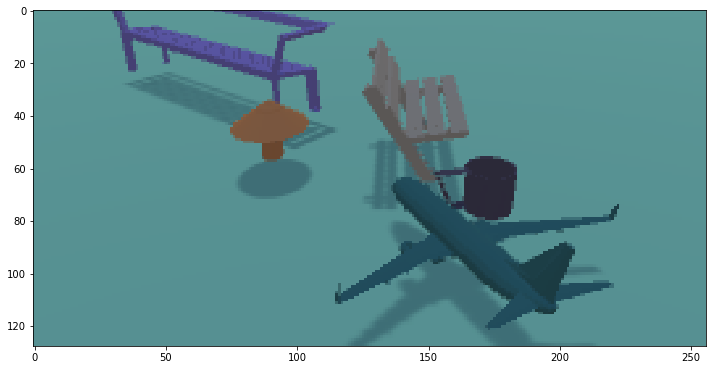

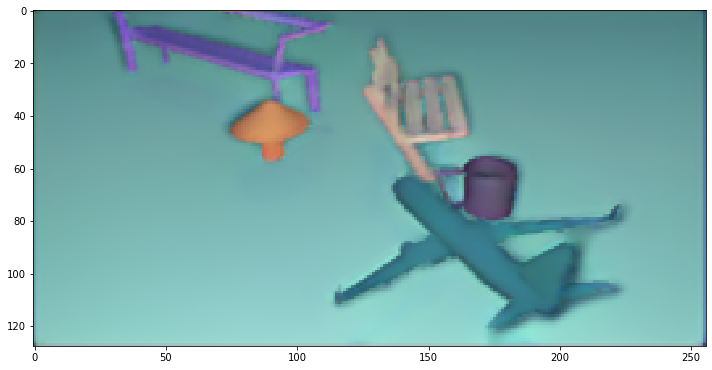

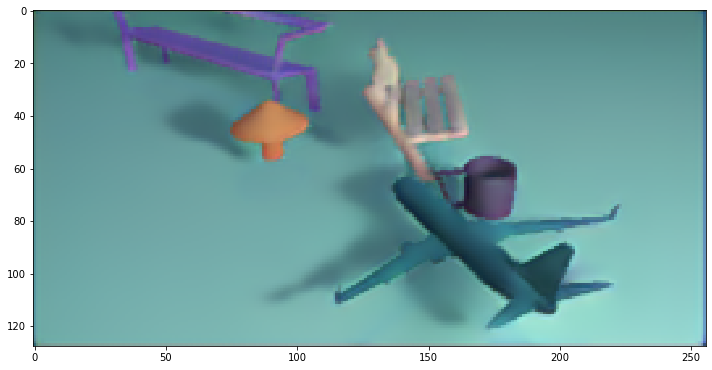

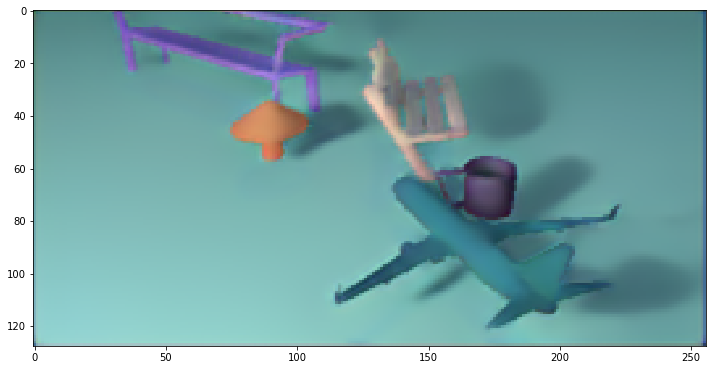

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


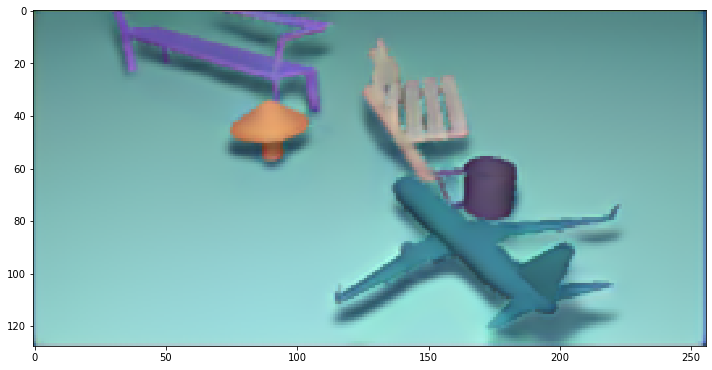

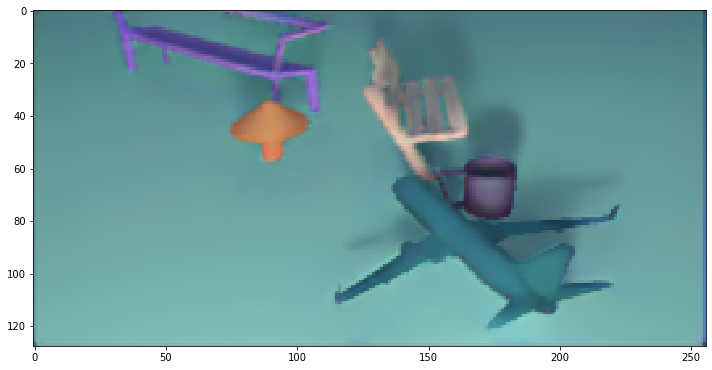

In [70]:
pred = unet_s.predict(batch_inputs) # <<<----variable

print(pred.shape)
# print("Input:")
show_img(batch_inputs[0, :, :, 0:3])
# print("Center:")
show_img(pred[0, :, :, :])
# print("Right:")
show_img(pred[1, :, :, :])
# print("Left:")
show_img(pred[2, :, :, :])
# print("Up:")
show_img(pred[3, :, :, :])
# print("Down:")
show_img(pred[4, :, :, :])

(40, 128, 256, 3)


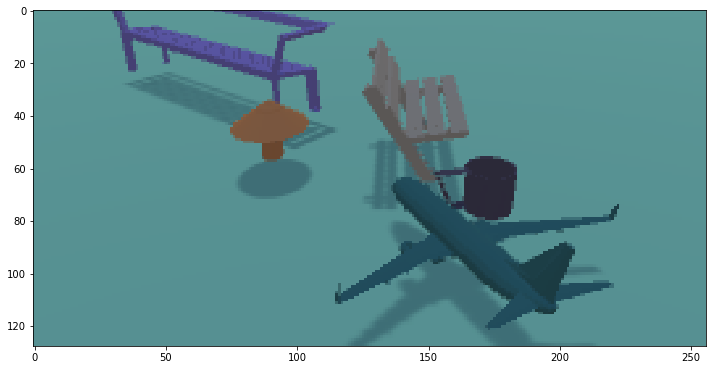

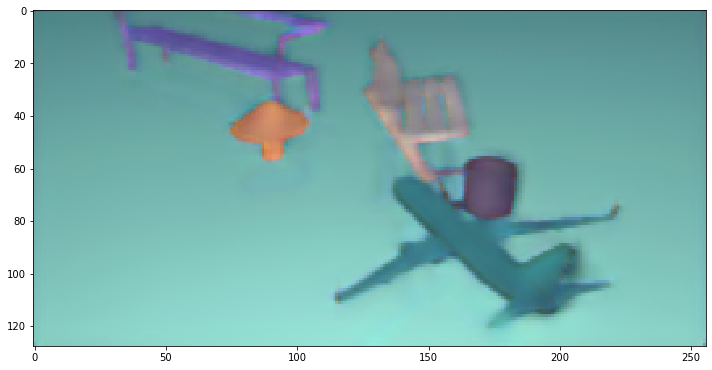

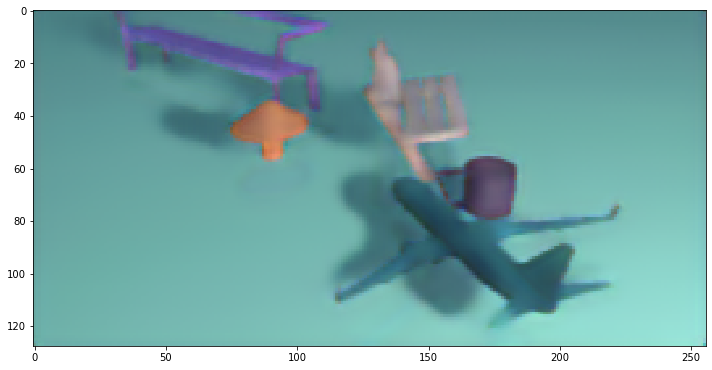

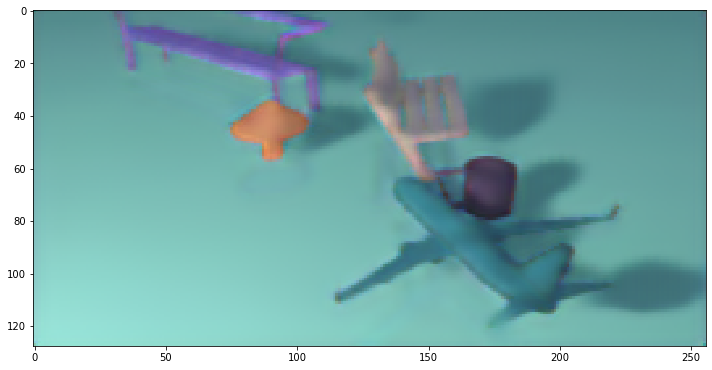

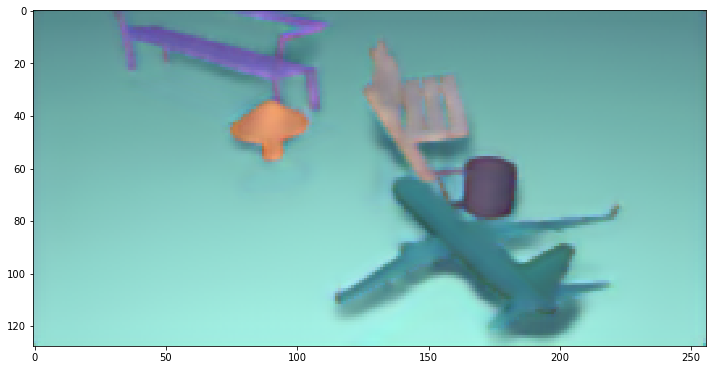

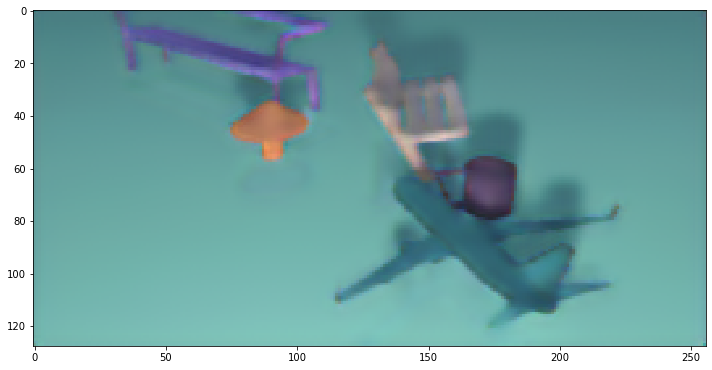

In [78]:
pred = unet_mae.predict(batch_inputs) # <<<----variable

print(pred.shape)
# print("Input:")
show_img(batch_inputs[0, :, :, 0:3])
# print("Center:")
show_img(pred[0, :, :, :])
# print("Right:")
show_img(pred[1, :, :, :])
# print("Left:")
show_img(pred[2, :, :, :])
# print("Up:")
show_img(pred[3, :, :, :])
# print("Down:")
show_img(pred[4, :, :, :])

(40, 128, 256, 3)


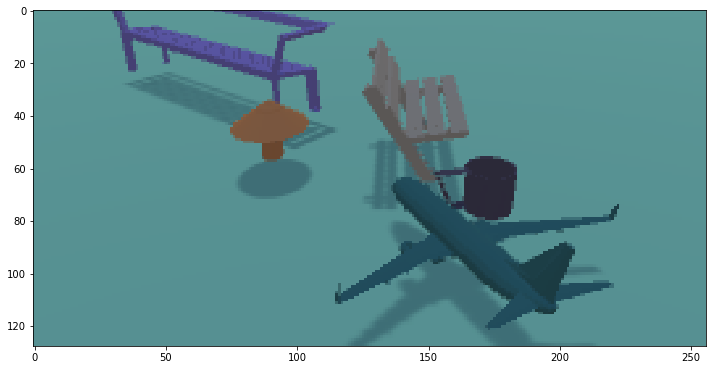

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


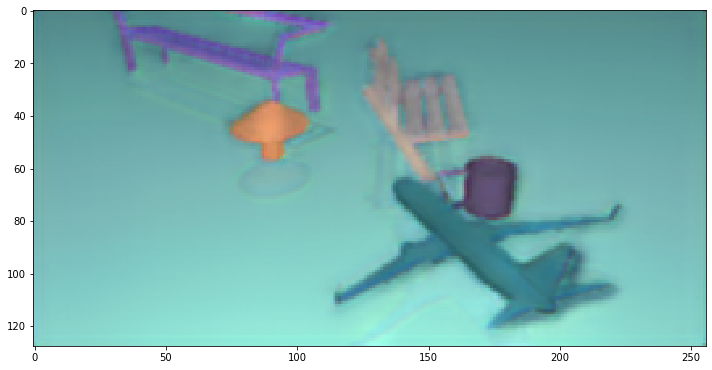

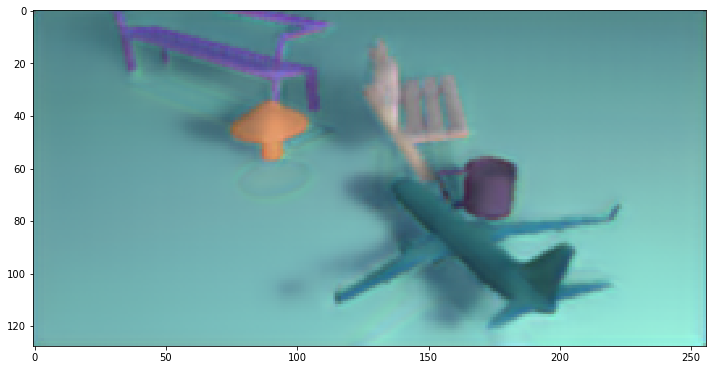

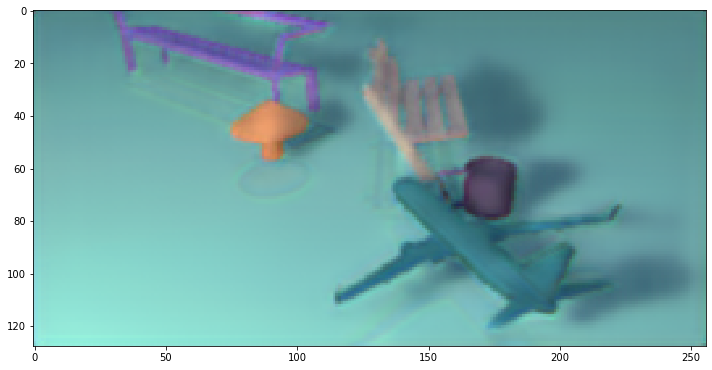

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


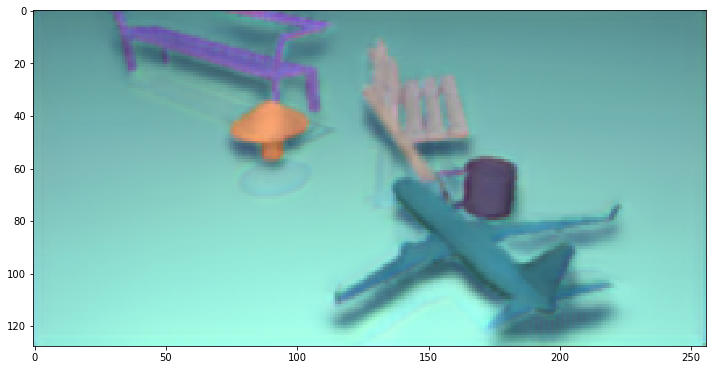

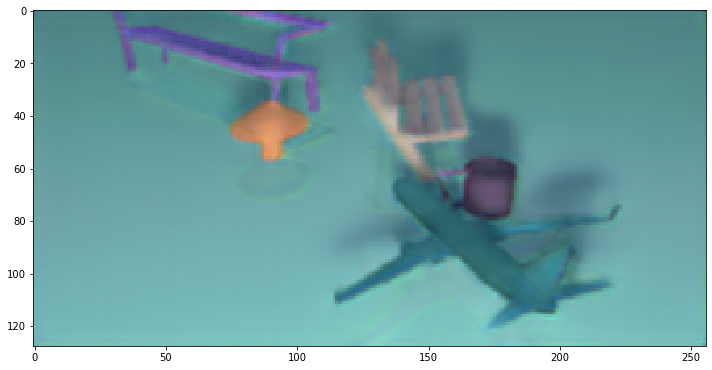

In [77]:
pred = unet_mse.predict(batch_inputs) # <<<----variable

print(pred.shape)
# print("Input:")
show_img(batch_inputs[0, :, :, 0:3])
# print("Center:")
show_img(pred[0, :, :, :])
# print("Right:")
show_img(pred[1, :, :, :])
# print("Left:")
show_img(pred[2, :, :, :])
# print("Up:")
show_img(pred[3, :, :, :])
# print("Down:")
show_img(pred[4, :, :, :])

Input:


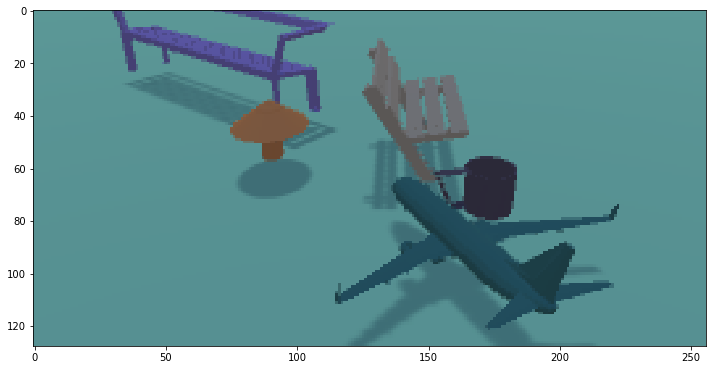

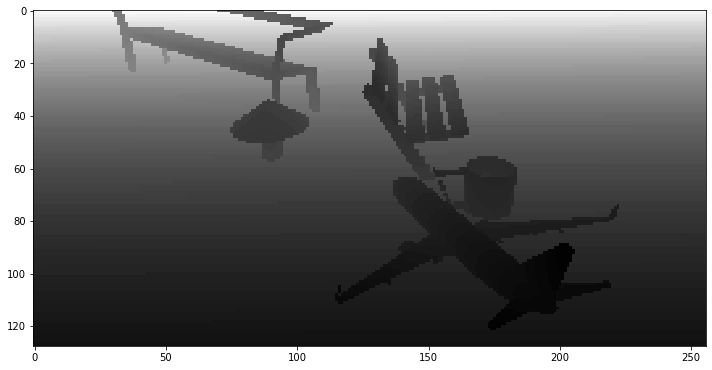

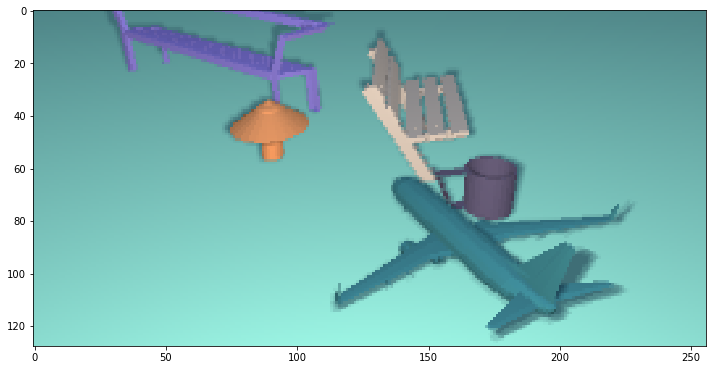

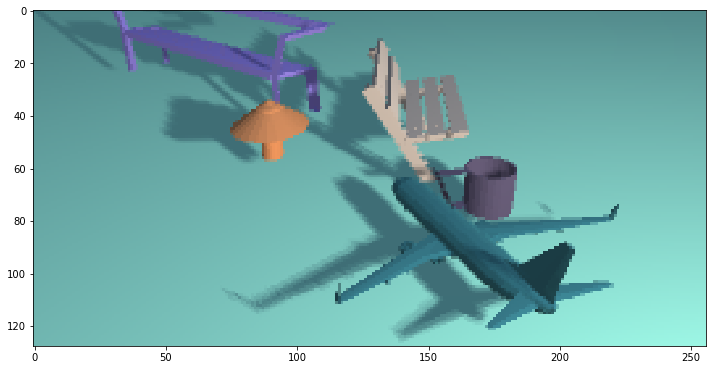

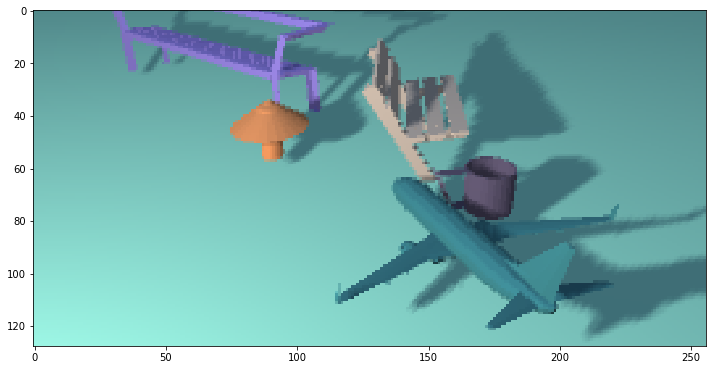

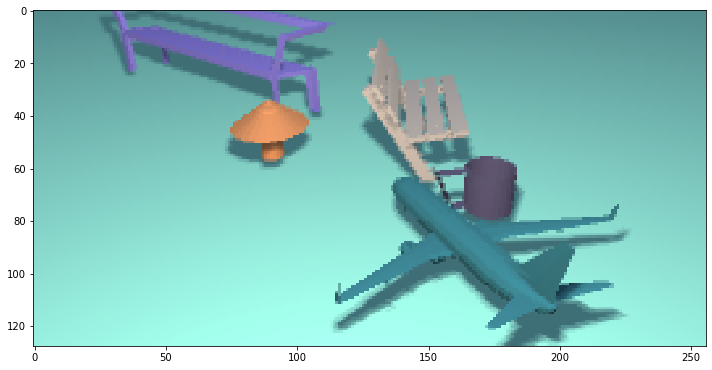

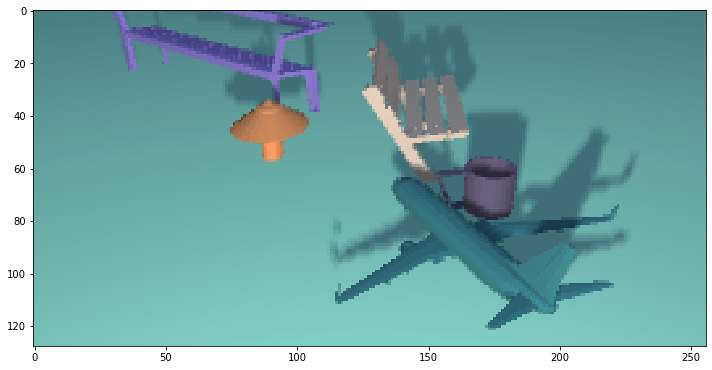

In [73]:
print("Input:")
show_img(batch_inputs[0, :, :, 0:3])
plt.imshow(batch_inputs[0, :, :, 3].astype(numpy.float32), interpolation='nearest', cmap='gray')
plt.show()
# print("GT.Center:")
show_img(batch_outputs[0, :, :, :])
# print("GT.Right:")
show_img(batch_outputs[1, :, :, :])
# print("GT.Left:")
show_img(batch_outputs[2, :, :, :])
# print("GT.Up:")
show_img(batch_outputs[3, :, :, :])
# print("GT.Down:")
show_img(batch_outputs[4, :, :, :])